In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

## The model in theory

We are going to use 4 features: The **price** itself and three extra technical indicators.
- MACD (Trend)
- Stochastics (Momentum)
- Average True Range (Volume)

## Functions

**Exponential Moving Average:** Is a type of infinite impulse response filter that applies weighting factors which decrease exponentially. The weighting for each older datum decreases exponentially, never reaching zero. 
<img src="https://www.bionicturtle.com/images/uploads/WindowsLiveWriterGARCHapproachandExponentialsmoothingEWMA_863image_16.png">

**MACD:**  The Moving Average Convergence/Divergence oscillator (MACD) is one of the simplest and most effective momentum indicators available. The MACD turns two trend-following indicators, moving averages, into a momentum oscillator by subtracting the longer moving average from the shorter moving average.
<img src="http://i68.tinypic.com/289ie1l.png">

**Stochastics oscillator:** The Stochastic Oscillator is a momentum indicator that shows the location of the close relative to the high-low range over a set number of periods.

<img src="http://i66.tinypic.com/2vam3uo.png">

**Average True Range:** Is an indicator to measure the volalitility (NOT price direction). The largest of:
- Method A: Current High less the current Low
- Method B: Current High less the previous Close (absolute value)
- Method C: Current Low less the previous Close (absolute value)

<img src="http://d.stockcharts.com/school/data/media/chart_school/technical_indicators_and_overlays/average_true_range_atr/atr-1-trexam.png" width="400px">

Calculation:
<img src="http://i68.tinypic.com/e0kggi.png">

In [2]:
def MACD(df,period1,period2,periodSignal):
    EMA1 = pd.DataFrame.ewm(df,span=period1).mean()
    EMA2 = pd.DataFrame.ewm(df,span=period2).mean()
    MACD = EMA1-EMA2
    
    Signal = pd.DataFrame.ewm(MACD,periodSignal).mean()
    
    Histogram = MACD-Signal
    
    return Histogram

def stochastics_oscillator(df,period):
    l, h = pd.DataFrame.rolling(df, period).min(), pd.DataFrame.rolling(df, period).max()
    k = 100 * (df - l) / (h - l)
    return k

def ATR(df,period):
    '''
    Method A: Current High less the current Low
    '''
    df['H-L'] = abs(df['High']-df['Low'])
    df['H-PC'] = abs(df['High']-df['Price'].shift(1))
    df['L-PC'] = abs(df['Low']-df['Price'].shift(1))
    TR = df[['H-L','H-PC','L-PC']].max(axis=1)
    return TR.to_frame()

## Read data

In [3]:
df = pd.read_csv('BTCUSD.csv',usecols=[1,2,3,4])
df = df.iloc[::-1]
df["Price"] = (df["Price"].str.split()).apply(lambda x: float(x[0].replace(',', '')))
df["Open"] = (df["Open"].str.split()).apply(lambda x: float(x[0].replace(',', '')))
df["High"] = (df["High"].str.split()).apply(lambda x: float(x[0].replace(',', '')))
df["Low"] = (df["Low"].str.split()).apply(lambda x: float(x[0].replace(',', '')))


dfPrices = pd.read_csv('BTCUSD.csv',usecols=[1])
dfPrices = dfPrices.iloc[::-1]
dfPrices["Price"] = (dfPrices["Price"].str.split()).apply(lambda x: float(x[0].replace(',', '')))

In [4]:
dfPrices.head(2)

,Price
2031,6.10
2030,5.96


## Plot

In [5]:
price = dfPrices.iloc[len(dfPrices.index)-60:len(dfPrices.index)].as_matrix().ravel()

### Price

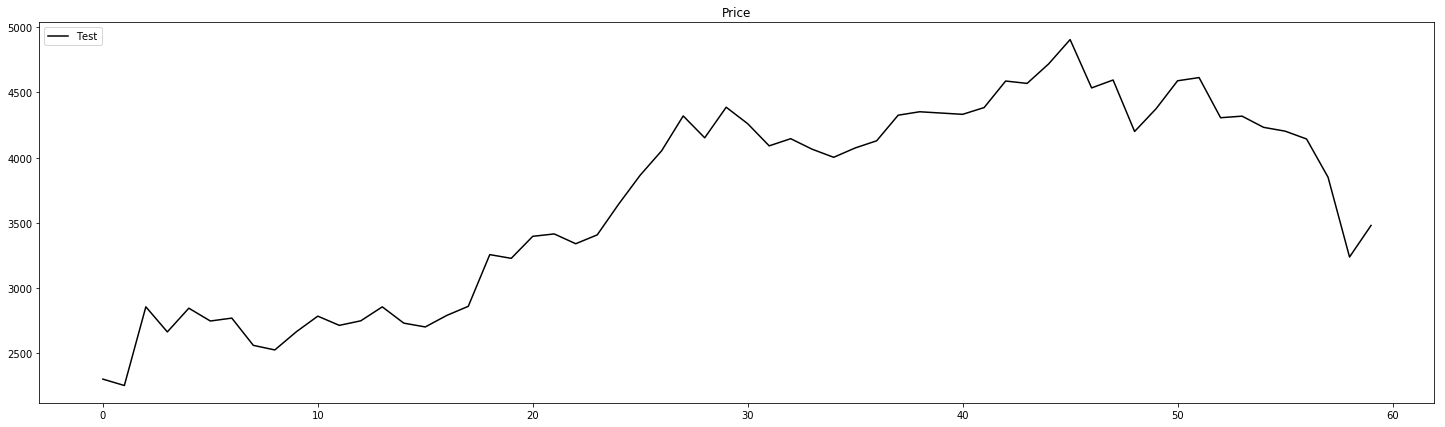

In [6]:
prices = dfPrices.iloc[len(dfPrices.index)-60:len(dfPrices.index)].as_matrix().ravel()
plt.figure(figsize=(25,7))
plt.plot(prices,label='Test',color='black')
plt.title('Price')
plt.legend(loc='upper left')
plt.show()

### MACD

In [7]:
macd = MACD(dfPrices.iloc[len(dfPrices.index)-60:len(dfPrices.index)],12,26,9)

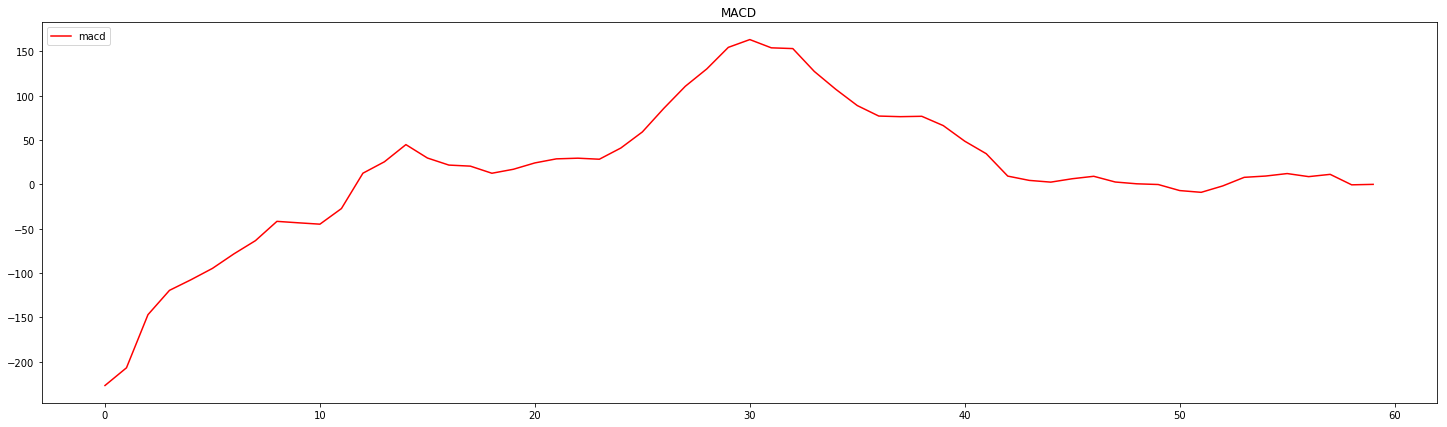

In [8]:
plt.figure(figsize=(25,7))
plt.plot(macd,label='macd',color='red')
plt.title('MACD')
plt.legend(loc='upper left')
plt.show()

### Stochastics Oscillator

In [9]:
stochastics = stochastics_oscillator(dfPrices.iloc[len(dfPrices.index)-60:len(dfPrices.index)],14)

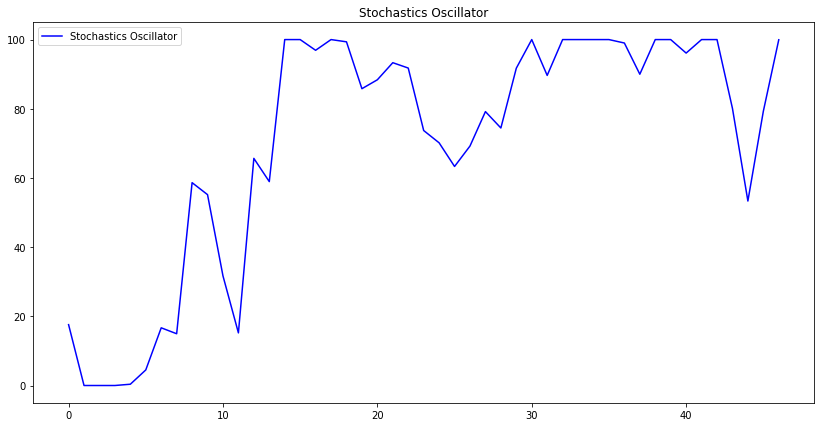

In [10]:
plt.figure(figsize=(14,7))
#First 100 points because it's too dense
plt.plot(stochastics[0:100],label='Stochastics Oscillator',color='blue')
plt.title('Stochastics Oscillator')
plt.legend(loc='upper left')
plt.show()

### Average True Range

In [11]:
atr = ATR(df.iloc[len(df.index)-60:len(df.index)],14)

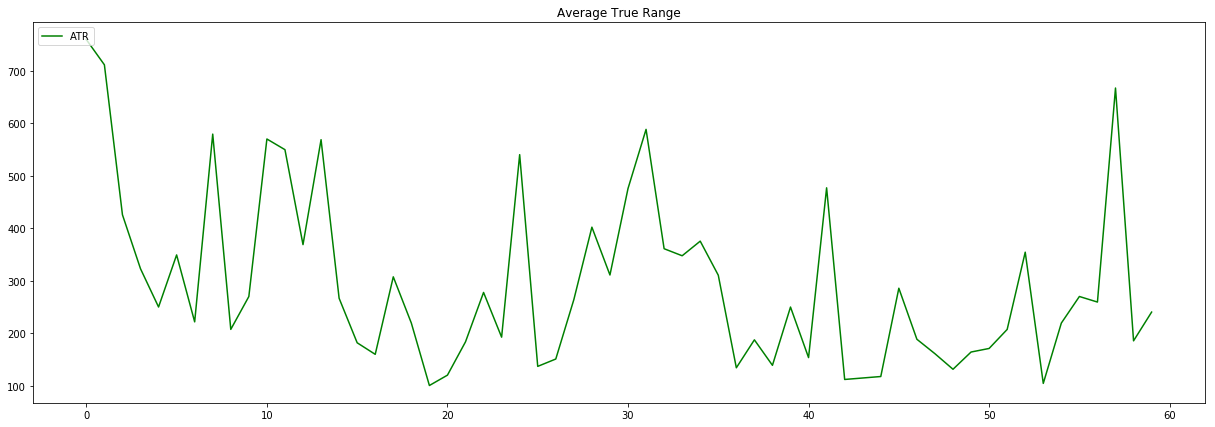

In [12]:
plt.figure(figsize=(21,7))
#First 100 points because it's too dense
plt.plot(atr[0:100],label='ATR',color='green')
plt.title('Average True Range')
plt.legend(loc='upper left')
plt.show()

## Create complete DataFrame & Save Data

In [13]:
dfPriceShift = dfPrices.shift(-1)
dfPriceShift.rename(columns={'Price':'PriceTarget'}, inplace=True)

In [14]:
dfPriceShift.head(2)

,PriceTarget
2031,5.96
2030,5.87


In [15]:
macd = MACD(dfPrices,12,26,9)
macd.rename(columns={'Price':'MACD'}, inplace=True)

In [16]:
stochastics = stochastics_oscillator(dfPrices,14)
stochastics.rename(columns={'Price':'Stochastics'}, inplace=True)

In [17]:
atr = ATR(df,14)
atr.rename(columns={0:'ATR'}, inplace=True)

In [18]:
final_data = pd.concat([dfPrices,dfPriceShift,macd,stochastics,atr], axis=1)
# Delete the entries with missing values (where the stochastics couldn't be computed yet) because have a lot of datapoints ;)
final_data = final_data.dropna()

In [19]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2018 entries, 2018 to 1
Data columns (total 5 columns):
Price          2018 non-null float64
PriceTarget    2018 non-null float64
MACD           2018 non-null float64
Stochastics    2018 non-null float64
ATR            2018 non-null float64
dtypes: float64(5)
memory usage: 94.6 KB


In [20]:
final_data

,Price,PriceTarget,MACD,Stochastics,ATR
2018,4.33,4.27,-0.108534,0.000000,0.13
2017,4.27,4.41,-0.129960,0.000000,0.06
2016,4.41,4.22,-0.131112,8.536585,0.14
2015,4.22,4.39,-0.136443,0.000000,0.19
2014,4.39,4.36,-0.124504,10.059172,0.17
2013,4.36,4.27,-0.112344,8.284024,0.03
2012,4.27,4.42,-0.103831,2.958580,0.09
2011,4.42,5.01,-0.083986,11.834320,0.15
2010,5.01,5.03,-0.030560,46.745562,0.59
2009,5.03,4.77,0.010302,58.695652,0.02


In [21]:
final_data.to_csv('BTCUSD_TechnicalIndicators.csv',index=False)